In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
x = 2024

url = f"https://fbref.com/en/comps/19/{x}-{x+1}/schedule/{x}-{x+1}-Europa-League-Scores-and-Fixtures"
# url = f'https://fbref.com/en/comps/8/{x}-{x+1}/schedule/{x}-{x+1}-Champions-League-Scores-and-Fixtures'
# url = f'https://fbref.com/en/comps/882/{x}-{x+1}/schedule/{x}-{x+1}-Conference-League-Scores-and-Fixtures'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

response = requests.get(url, headers=headers)

soup = BeautifulSoup(response.text, "html.parser")

In [6]:
table = soup.find("table", {"class": "stats_table"})

header_row = table.find("thead").find("tr") if table.find("thead") else table.find("tr")
headers = [th.text.strip() for th in header_row.find_all("th")]

# Extract rows
rows = []
for tr in table.find("tbody").find_all("tr"):  # Use tbody to avoid header rows
    cells = [td.text.strip() for td in tr.find_all("td")]
    if cells:  # Ignore empty rows
        rows.append(cells)

# Ensure column and row lengths match
if len(headers) > len(rows[0]):  # If there are extra headers
    headers = headers[-len(rows[0]):]  # Use only the last N headers matching the data

# Convert to DataFrame
df = pd.DataFrame(rows, columns=headers)

df[['Home', 'Home_Country']] = df['Home'].str.rsplit(n=1, expand=True)
df[['Away_Country', 'Away']] = df['Away'].str.split(n=1, expand=True)

df = df[['Date', 'Home', 'Away', 'Home_Country', 'Away_Country', 'Score']]

df.columns = ['date', 'hometeam', 'awayteam', 'homecountry', 'awaycountry', 'score']

df['score'] = df['score'].str.replace(r'\(.*?\)\s*', '', regex=True)

df[['homescore', 'awayscore']] = df['score'].str.split('–', expand=True)

# Convert the score columns to numeric
df['homescore'] = pd.to_numeric(df['homescore'])
df['awayscore'] = pd.to_numeric(df['awayscore'])

# Create a new column for match result
df['result'] = df.apply(
    lambda row: 0 if row['homescore'] > row['awayscore'] else (0.5 if row['homescore'] == row['awayscore'] else 1),
    axis=1
)

df.drop(columns=['score'], inplace=True)

df.dropna(inplace=True)

AttributeError: 'NoneType' object has no attribute 'find'

In [4]:
df.to_csv(f'europe/europa_league/{x}-{x+1}.csv')

NameError: name 'df' is not defined

In [7]:
import os
import pandas as pd

# Directory containing all the CSV files
directory = 'europe/europa_league/'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dfs = []

# Loop through all CSV files and read them into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, index_col=False)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV
combined_df.to_csv('europe/europa_league_all_seasons_combined.csv', index=False)

In [8]:
import pandas as pd

# Manually specify the CSV file names
file1 = 'europe/champions_league_all_seasons_combined.csv'
file2 = 'europe/europa_league_all_seasons_combined.csv'
file3 = 'europe/conference_league_all_seasons_combined.csv'

# Read the CSV files into DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

df1['competition'] = 'champions'
df2['competition'] = 'europa'
df3['competition'] = 'conference'

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

combined_df.sort_values('date', inplace=True)

import json

# Load the country code mapping JSON
with open('europe/country_codes.json', 'r', encoding='utf-8') as f:
    country_codes = json.load(f)

df = combined_df

df['homecountry_name'] = df['homecountry'].map(country_codes).str.lower()
df['awaycountry_name'] = df['awaycountry'].map(country_codes).str.lower()

df['result'] = 1 - df['result']

# Display the updated DataFrame
df

# Save the combined DataFrame to a new CSV
df.to_csv('europe/all_competitions_combined.csv', index=False, encoding='utf-8')

In [9]:
df = pd.read_csv('europe/all_competitions_combined.csv')

# df = df[df['date']>'2005-01-01']

initial_elo = 1500
elo_ratings = {}
match_counts = {}  # Track number of matches per country

def calculate_elo(home_country, away_country, result, elo_ratings, match_counts, K_base=50):
    if home_country not in elo_ratings:
        elo_ratings[home_country] = initial_elo
        match_counts[home_country] = 0
    
    if away_country not in elo_ratings:
        elo_ratings[away_country] = initial_elo
        match_counts[away_country] = 0

    home_elo = elo_ratings[home_country]
    away_elo = elo_ratings[away_country]

    # Adjusted K-factor: decreases gradually but doesn't drop too much
    scaling_factor = 25  # Controls how fast K decreases (tweak if needed)
    home_K = max(K_base / (1 + match_counts[home_country] / scaling_factor), 10)
    away_K = max(K_base / (1 + match_counts[away_country] / scaling_factor), 10)

    expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
    expected_away = 1 / (1 + 10 ** ((home_elo - away_elo) / 400))

    actual_home, actual_away = (1, 0) if result == 1 else (0, 1) if result == 0 else (0.5, 0.5)

    new_home_elo = home_elo + home_K * (actual_home - expected_home)
    new_away_elo = away_elo + away_K * (actual_away - expected_away)

    elo_ratings[home_country] = new_home_elo
    elo_ratings[away_country] = new_away_elo
    match_counts[home_country] += 1
    match_counts[away_country] += 1

    return elo_ratings, match_counts

# Process each match
for index, row in df.iterrows():
    home_country = row['homecountry_name']
    away_country = row['awaycountry_name']
    result = row['result']
    elo_ratings, match_counts = calculate_elo(home_country, away_country, result, elo_ratings, match_counts)

# Sort Elo rankings
elo_ranking = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame for final ranking
elo_df = pd.DataFrame(elo_ranking, columns=['Country', 'Elo Rating'])

elo_df["Elo Normalized"] = (elo_df["Elo Rating"] - elo_df["Elo Rating"].min()) / (elo_df["Elo Rating"].max() - elo_df["Elo Rating"].min())
print(elo_df.head(100))

                   Country   Elo Rating  Elo Normalized
0                  england  1737.280511        1.000000
1                    spain  1701.602008        0.916690
2                    italy  1678.259336        0.862184
3                  germany  1643.264807        0.780471
4                   france  1628.165378        0.745214
5                 portugal  1621.569712        0.729812
6              netherlands  1619.505585        0.724993
7                  belgium  1581.839883        0.637042
8                 scotland  1532.089546        0.520874
9                   turkey  1525.797618        0.506182
10                  poland  1522.021600        0.497365
11                 croatia  1519.461597        0.491388
12          czech republic  1516.415367        0.484275
13                  greece  1515.706598        0.482620
14                 denmark  1507.647217        0.463801
15                 romania  1506.405387        0.460901
16                  russia  1502.456990        0

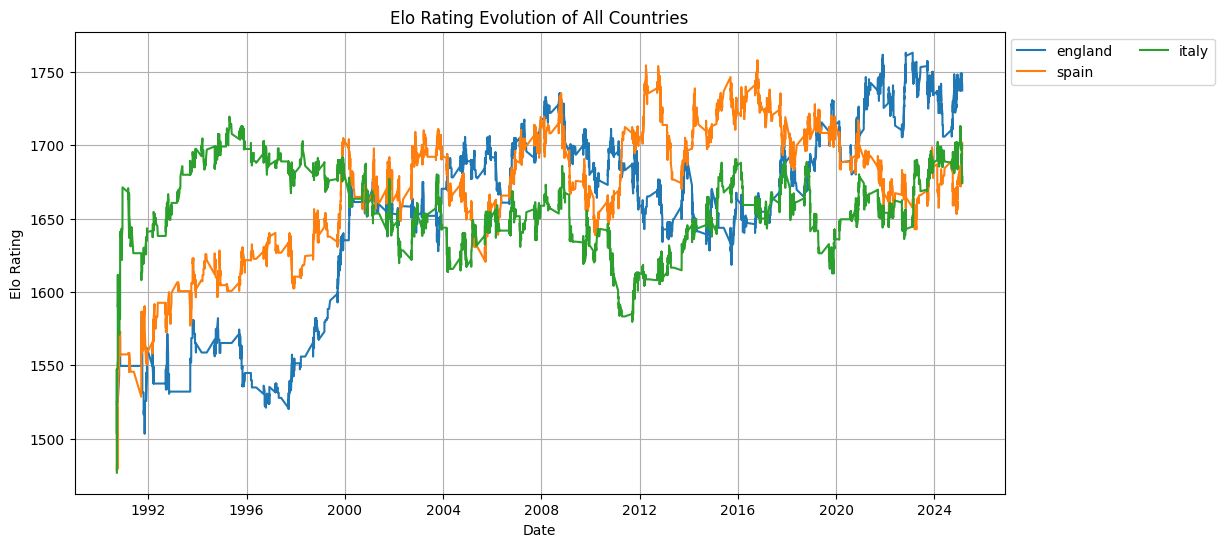

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

initial_elo = 1500
elo_ratings = {}
match_counts = {}
elo_history = []  # Track Elo evolution over time

# Process each match
for index, row in df.iterrows():
    home_country = row['homecountry_name']
    away_country = row['awaycountry_name']
    result = row['result']
    match_date = row['date']  # Store date for graph tracking

    # Update Elo ratings
    elo_ratings, match_counts = calculate_elo(home_country, away_country, result, elo_ratings, match_counts)

    # Track Elo ratings for all countries
    history_entry = {"date": match_date}
    history_entry.update(elo_ratings)
    elo_history.append(history_entry)

# Convert Elo history to DataFrame
elo_evolution_df = pd.DataFrame(elo_history)
elo_evolution_df["date"] = pd.to_datetime(elo_evolution_df["date"])  # Convert dates
elo_evolution_df = elo_evolution_df.sort_values("date")  # Sort by date

# Plot Elo evolution for all countries
plt.figure(figsize=(12, 6))

latest_elo_values = elo_evolution_df.iloc[-1].drop("date")  # Get the last row, excluding date
top5 = latest_elo_values.sort_values(ascending=False).iloc[:3].keys()

for country in top5:
    plt.plot(elo_evolution_df["date"], elo_evolution_df[country], label=country)

plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)  # Adjust legend position
plt.grid(True)
plt.title("Elo Rating Evolution of All Countries")
plt.show()


In [11]:
import pandas as pd

# Load dataset
df = pd.read_csv('europe/all_competitions_combined.csv')

# df = df[df['date']<'2025-01-31']

# Uncomment to filter matches after a specific date
# df = df[df['date'] > '2005-01-01']

# Initialize Elo ratings and match counts
initial_elo = 1500
elo_ratings = {}
match_counts = {}  # Track number of matches per team

def calculate_elo(home_team, away_team, result, elo_ratings, match_counts, K_base=50):
    if home_team not in elo_ratings:
        elo_ratings[home_team] = initial_elo
        match_counts[home_team] = 0
    
    if away_team not in elo_ratings:
        elo_ratings[away_team] = initial_elo
        match_counts[away_team] = 0

    home_elo = elo_ratings[home_team]
    away_elo = elo_ratings[away_team]

    # Adjusted K-factor: decreases gradually but doesn't drop too much
    scaling_factor = 25  # Controls how fast K decreases
    home_K = max(K_base / (1 + match_counts[home_team] / scaling_factor), 10)
    away_K = max(K_base / (1 + match_counts[away_team] / scaling_factor), 10)

    expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
    expected_away = 1 / (1 + 10 ** ((home_elo - away_elo) / 400))

    actual_home, actual_away = (1, 0) if result == 1 else (0, 1) if result == 0 else (0.5, 0.5)

    new_home_elo = home_elo + home_K * (actual_home - expected_home)
    new_away_elo = away_elo + away_K * (actual_away - expected_away)

    elo_ratings[home_team] = new_home_elo
    elo_ratings[away_team] = new_away_elo
    match_counts[home_team] += 1
    match_counts[away_team] += 1

    return elo_ratings, match_counts

# Process each match
for index, row in df.iterrows():
    home_team = row['hometeam']
    away_team = row['awayteam']
    result = row['result']
    elo_ratings, match_counts = calculate_elo(home_team, away_team, result, elo_ratings, match_counts)

# Sort Elo rankings (highest Elo first)
elo_ranking = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame for final ranking
elo_df = pd.DataFrame(elo_ranking, columns=['Team', 'Elo Rating'])

# Print top 100 teams
print(elo_df.head(15))

               Team   Elo Rating
0     Bayern Munich  1811.401546
1       Real Madrid  1809.814433
2         Barcelona  1755.507048
3   Manchester City  1754.374764
4           Chelsea  1749.797286
5         Liverpool  1744.468494
6         Paris S-G  1715.082971
7           Arsenal  1704.912899
8          Juventus  1701.564279
9   Atlético Madrid  1700.967820
10            Inter  1696.522054
11   Manchester Utd  1695.892153
12         Dortmund  1673.494174
13    Newcastle Utd  1660.380633
14         West Ham  1657.694910


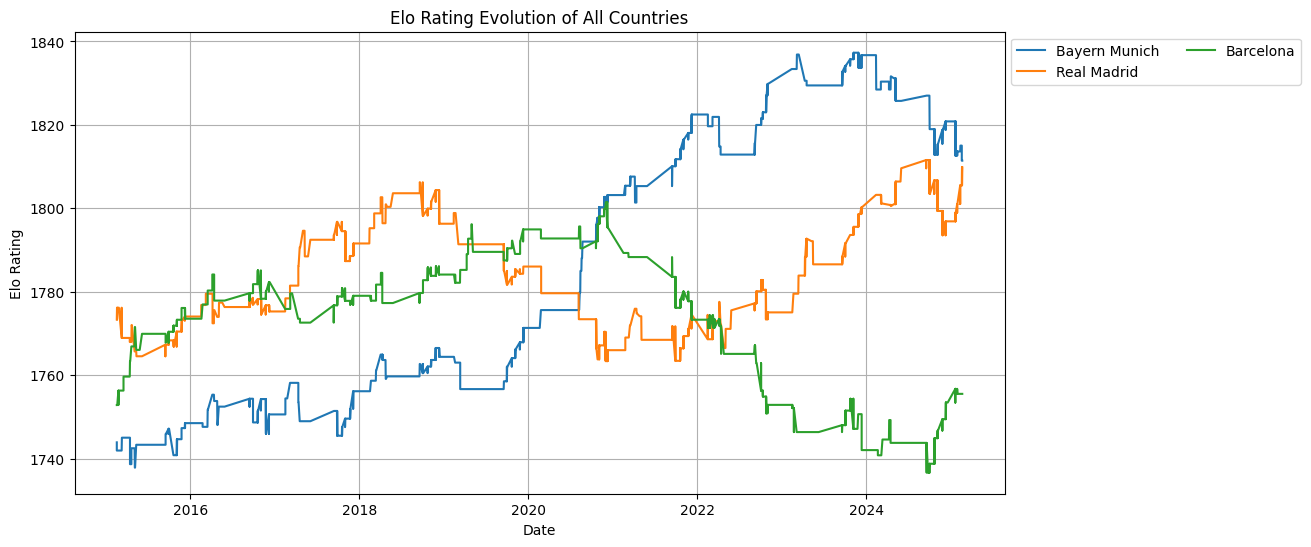

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

initial_elo = 1500
elo_ratings = {}
match_counts = {}
elo_history = []  # Track Elo evolution over time

# Process each match
for index, row in df.iterrows():
    home_country = row['hometeam']
    away_country = row['awayteam']
    result = row['result']
    match_date = row['date']  # Store date for graph tracking

    # Update Elo ratings
    elo_ratings, match_counts = calculate_elo(home_country, away_country, result, elo_ratings, match_counts)

    # Track Elo ratings for all countries
    history_entry = {"date": match_date}
    history_entry.update(elo_ratings)
    elo_history.append(history_entry)

# Convert Elo history to DataFrame
elo_evolution_df = pd.DataFrame(elo_history)
elo_evolution_df["date"] = pd.to_datetime(elo_evolution_df["date"])  # Convert dates
elo_evolution_df = elo_evolution_df.sort_values("date")  # Sort by date

# Plot Elo evolution for all countries
plt.figure(figsize=(12, 6))

latest_elo_values = elo_evolution_df.iloc[-1].drop("date")  # Get the last row, excluding date
top5 = latest_elo_values.sort_values(ascending=False).iloc[:3].keys()

elo_evolution_df = elo_evolution_df[elo_evolution_df['date']>'2015-01-01']

for country in top5:
    plt.plot(elo_evolution_df["date"], elo_evolution_df[country], label=country)

plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)  # Adjust legend position
plt.grid(True)
plt.title("Elo Rating Evolution of All Countries")
plt.show()